# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

#to display more than one output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=";")


In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()
azdias.describe()
azdias.info()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
feat_info.head(n=16)
feat_info.describe()
feat_info.info()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,PLZ8_ANTG2,person,ordinal,[-1]
freq,1,43,49,26


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
#extract the names of columns
col_names = azdias.columns
col_names

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [6]:
#make attribute column values as row labels so i can use it with loc 
feat_info.set_index('attribute', inplace=True)


In [ ]:
#Identify missing or unknown data values and convert them to NaNs.
#for loop to go through all columns in azdias, and map to apply the function on all values.

for col in col_names:
    azdias[col] = azdias[col].map(lambda x: np.nan if str(x) in feat_info.loc[col].missing_or_unknown else x)

In [ ]:
#Save the result into a new df to save the time    
azdias.to_csv('azdias_new.csv', sep=';', index = False)


In [7]:
#Load the data after replace NANs
azdias_new = pd.read_csv('azdias_new.csv', delimiter=';')

In [8]:
azdias_new.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,NaN,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,NaN,4.0,NaN,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,NaN,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,NaN,5.0,4.0,3.0,4.0,NaN,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
#https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset/51071037
count_missing = azdias_new.isna().sum()
percent_missing = count_missing * 100 / len(azdias_new)

count_missing
percent_missing


AGER_TYP                 765645
ALTERSKATEGORIE_GROB     145768
ANREDE_KZ                425916
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST        139587
FINANZ_SPARER            250213
FINANZ_VORSORGER         104369
FINANZ_ANLEGER           210812
FINANZ_UNAUFFAELLIGER    220597
FINANZ_HAUSBAUER         143104
FINANZTYP                199572
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               273584
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         792400
PRAEGENDE_JUGENDJAHRE    129446
RETOURTYP_BK_S             4854
SEMIO_SOZ                 62088
SEMIO_FAM                 81916
SEMIO_REL                108130
SEMIO_MAT                 97341
SEMIO_VERT               120437
SEMIO_LUST               110382
                          ...  
OST_WEST

AGER_TYP                 85.909668
ALTERSKATEGORIE_GROB     16.355988
ANREDE_KZ                47.790167
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST        15.662445
FINANZ_SPARER            28.075303
FINANZ_VORSORGER         11.710788
FINANZ_ANLEGER           23.654290
FINANZ_UNAUFFAELLIGER    24.752222
FINANZ_HAUSBAUER         16.057072
FINANZTYP                22.393099
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               30.697661
LP_LEBENSPHASE_FEIN       0.544646
LP_LEBENSPHASE_GROB       0.544646
LP_FAMILIE_FEIN           0.544646
LP_FAMILIE_GROB           0.544646
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         88.911729
PRAEGENDE_JUGENDJAHRE    14.524568
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 6.966622
SEMIO_FAM                 9.191435
SEMIO_REL                12.132793
SEMIO_MAT                10.922207
SEMIO_VERT          

(array([ 12.,  14.,  30.,  17.,   0.,   3.,   2.,   0.,   0.,   2.,   1.,
          0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   2.]),
 array([  0.        ,   4.44558645,   8.8911729 ,  13.33675934,
         17.78234579,  22.22793224,  26.67351869,  31.11910514,
         35.56469159,  40.01027803,  44.45586448,  48.90145093,
         53.34703738,  57.79262383,  62.23821028,  66.68379672,
         71.12938317,  75.57496962,  80.02055607,  84.46614252,  88.91172897]),
 <a list of 20 Patch objects>)

Text(0.5,0,'Percentage of missing value')

Text(0,0.5,'number of columns')

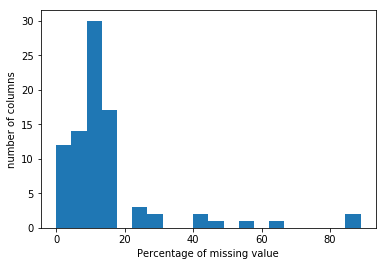

In [10]:
# Investigate patterns in the amount of missing data in each column.
#https://www.youtube.com/watch?v=snkkKrek7TU
plt.hist(percent_missing, bins=20)

plt.xlabel('Percentage of missing value')
plt.ylabel('number of columns')
plt.show()


In [11]:
#convert to df
percent_missing=pd.DataFrame(percent_missing)
# Change the column name 
percent_missing.columns =['percent'] 

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# drop the columns smaller than 19 and keep the largest because I want to drop it from the original dataset
drop_features=percent_missing.drop(percent_missing[percent_missing.percent < 19].index)
drop_features
drop_features_names = drop_features.index
drop_features_names


,percent
AGER_TYP,85.909668
ANREDE_KZ,47.790167
FINANZ_SPARER,28.075303
FINANZ_ANLEGER,23.654290
FINANZ_UNAUFFAELLIGER,24.752222
FINANZTYP,22.393099
GEBURTSJAHR,44.020282
HEALTH_TYP,30.697661
NATIONALITAET_KZ,88.911729
SHOPPER_TYP,41.062430


Index(['AGER_TYP', 'ANREDE_KZ', 'FINANZ_SPARER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZTYP', 'GEBURTSJAHR', 'HEALTH_TYP',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'KK_KUNDENTYP'],
      dtype='object')

In [13]:
for features in drop_features_names:
    azdias_new.drop(features, axis=1, inplace=True)

azdias_new    

,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,2.0,3.0,3.0,3.0,10.0,0,15.0,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,5.0,NaN,2.0,5.0,10.0,0,21.0,6.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,3.0,NaN,NaN,5.0,10.0,1,3.0,1.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,4.0,5.0,2.0,1.0,0,0.0,0.0,0.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,5.0,4.0,4.0,2.0,5.0,0,32.0,10.0,10.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,NaN,2.0,3.0,5.0,5.0,1.0,0,8.0,2.0,1.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,5.0,NaN,NaN,3.0,12.0,0,2.0,1.0,1.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,3.0,3.0,4.0,2.0,9.0,0,5.0,2.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,3.0,4.0,2.0,2.0,3.0,1,10.0,3.0,1.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,4.0,2.0,2.0,4.0,12.0,1,4.0,1.0,1.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

- from the histogram I saw that most of the columns have 20% missing values and more so, I decide to remove all the columns that have more than to 19% of missing values because it has a lot of NANs compare to the others.
 the columns are 'AGER_TYP', 'ANREDE_KZ', 'FINANZ_SPARER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZTYP', 'GEBURTSJAHR', 'HEALTH_TYP',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP' and 'KK_KUNDENTYP'

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# How much data is missing in each row of the dataset?
count_missing_rows=azdias_new.isna().sum(axis=1)
count_missing_rows

percent_missing_rows=count_missing_rows * 100 / azdias_new.shape[1]
percent_missing_rows

0         43
1          3
2          3
3          3
4          0
5          1
6          2
7          4
8          3
9          4
10         1
11        43
12         9
13        12
14        43
15         9
16         5
17        43
18         3
19         1
20        12
21         2
22         2
23        11
24        43
25         4
26        23
27         1
28         1
29         3
          ..
891191     0
891192     2
891193     0
891194     2
891195     5
891196     2
891197     4
891198     2
891199     0
891200     3
891201     1
891202     2
891203    14
891204     4
891205     0
891206     3
891207     3
891208     3
891209     3
891210     1
891211     0
891212     3
891213     0
891214     3
891215     1
891216     6
891217     0
891218     1
891219     2
891220     0
Length: 891221, dtype: int64

0         58.904110
1          4.109589
2          4.109589
3          4.109589
4          0.000000
5          1.369863
6          2.739726
7          5.479452
8          4.109589
9          5.479452
10         1.369863
11        58.904110
12        12.328767
13        16.438356
14        58.904110
15        12.328767
16         6.849315
17        58.904110
18         4.109589
19         1.369863
20        16.438356
21         2.739726
22         2.739726
23        15.068493
24        58.904110
25         5.479452
26        31.506849
27         1.369863
28         1.369863
29         4.109589
            ...    
891191     0.000000
891192     2.739726
891193     0.000000
891194     2.739726
891195     6.849315
891196     2.739726
891197     5.479452
891198     2.739726
891199     0.000000
891200     4.109589
891201     1.369863
891202     2.739726
891203    19.178082
891204     5.479452
891205     0.000000
891206     4.109589
891207     4.109589
891208     4.109589
891209     4.109589


(array([  4.59406000e+05,   2.25959000e+05,   5.80490000e+04,
          1.07910000e+04,   2.11210000e+04,   7.39400000e+03,
          4.71800000e+03,   4.61900000e+03,   4.65600000e+03,
          9.39000000e+02,   3.37000000e+02,   3.40000000e+01,
          4.20000000e+01,   6.84000000e+02,   1.27140000e+04,
          5.63600000e+03,   5.23000000e+02,   7.35030000e+04,
          6.80000000e+01,   2.80000000e+01]),
 array([  0.        ,   3.42465753,   6.84931507,  10.2739726 ,
         13.69863014,  17.12328767,  20.54794521,  23.97260274,
         27.39726027,  30.82191781,  34.24657534,  37.67123288,
         41.09589041,  44.52054795,  47.94520548,  51.36986301,
         54.79452055,  58.21917808,  61.64383562,  65.06849315,  68.49315068]),
 <a list of 20 Patch objects>)

Text(0.5,0,'percent of missing value %')

Text(0,0.5,'number of rows')

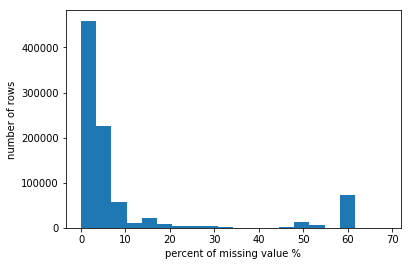

In [15]:
#show hist
plt.hist(percent_missing_rows, bins=20)

plt.xlabel('percent of missing value %')
plt.ylabel('number of rows')
plt.show()

In [16]:
#convert to df
percent_missing_rows=pd.DataFrame(percent_missing_rows)
# Change the column name 
percent_missing_rows.columns =['percent_missing_rows'] 
percent_missing_rows

,percent_missing_rows
0,58.904110
1,4.109589
2,4.109589
3,4.109589
4,0.000000
5,1.369863
6,2.739726
7,5.479452
8,4.109589
9,5.479452


In [17]:
# I have merged the count column to the whole dataset 
azdias_new=azdias_new.join (percent_missing_rows) 

# Write code to divide the data into two subsets based on the number of missing
# values in each row.

subset_1=azdias_new[azdias_new['percent_missing_rows'] < 10]
subset_2=azdias_new[azdias_new['percent_missing_rows'] >= 10]

subset_1
subset_2



,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,percent_missing_rows
1,NaN,5.0,NaN,2.0,5.0,10.0,0,21.0,6.0,5.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,4.109589
2,3.0,3.0,NaN,NaN,5.0,10.0,1,3.0,1.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,4.109589
3,4.0,2.0,4.0,5.0,2.0,1.0,0,0.0,0.0,0.0,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.109589
4,3.0,5.0,4.0,4.0,2.0,5.0,0,32.0,10.0,10.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.000000
5,NaN,2.0,3.0,5.0,5.0,1.0,0,8.0,2.0,1.0,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,1.369863
6,2.0,5.0,NaN,NaN,3.0,12.0,0,2.0,1.0,1.0,...,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,2.739726
7,NaN,3.0,3.0,4.0,2.0,9.0,0,5.0,2.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0,5.479452
8,3.0,3.0,4.0,2.0,2.0,3.0,1,10.0,3.0,1.0,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,4.109589
9,3.0,4.0,2.0,2.0,4.0,12.0,1,4.0,1.0,1.0,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,5.479452
10,3.0,1.0,2.0,5.0,5.0,8.0,0,6.0,2.0,1.0,...,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0,1.369863


,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,percent_missing_rows
0,2.0,2.0,3.0,3.0,3.0,10.0,0,15.0,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.904110
11,2.0,6.0,3.0,3.0,3.0,5.0,0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.904110
12,3.0,6.0,5.0,4.0,NaN,10.0,0,23.0,6.0,5.0,...,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0,12.328767
13,NaN,5.0,NaN,3.0,2.0,12.0,1,3.0,1.0,1.0,...,1.0,1.0,1.0,1.0,3.0,3.0,3.0,6.0,4.0,16.438356
14,3.0,6.0,3.0,3.0,3.0,5.0,0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.904110
15,4.0,4.0,4.0,5.0,4.0,12.0,0,12.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,8.0,5.0,12.328767
17,2.0,6.0,3.0,3.0,3.0,5.0,0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.904110
20,2.0,4.0,4.0,NaN,NaN,11.0,1,10.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,1.0,16.438356
23,3.0,3.0,5.0,3.0,NaN,12.0,1,20.0,5.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,6.0,2.0,15.068493
24,3.0,6.0,3.0,3.0,3.0,5.0,0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.904110


In [18]:
len(subset_1) * 100 / len(azdias_new)
len(subset_2) * 100 / len(azdias_new)



83.41522473101509

16.58477526898491

In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
#https://stackoverflow.com/questions/43131274/how-do-i-plot-two-countplot-graphs-side-by-side-in-seaborn

def Compare_distribution(data1, data2, column):
    fig, ax =plt.subplots(1,2)
    sns.countplot(data1[column], ax=ax[0]).set_title('less than 10% of missing values')
    sns.countplot(data2[column], ax=ax[1]).set_title('more than or equal to 10% of missing values')
    fig.show()


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


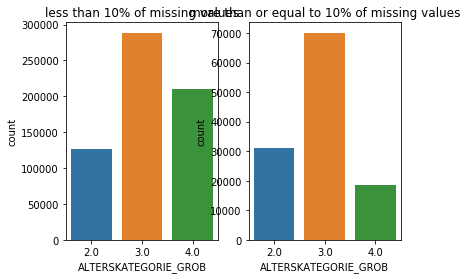

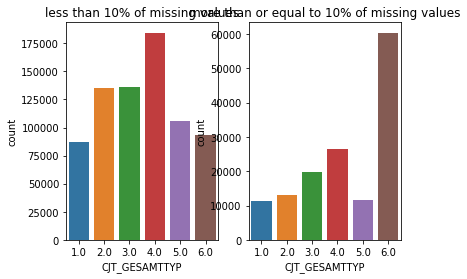

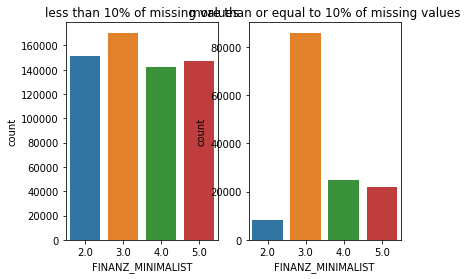

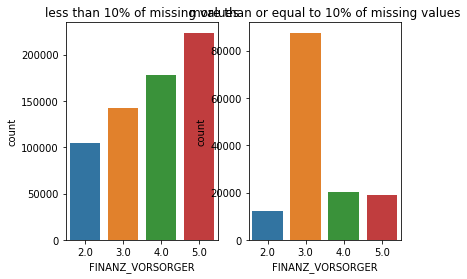

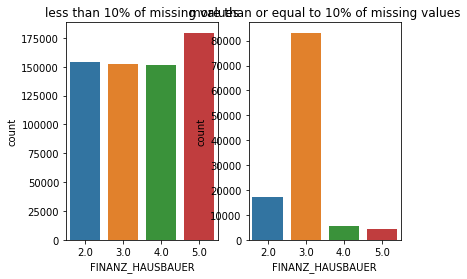

In [20]:
Compare_distribution(subset_1 , subset_2 , 'ALTERSKATEGORIE_GROB')
Compare_distribution(subset_1 , subset_2 , 'CJT_GESAMTTYP')
Compare_distribution(subset_1 , subset_2 , 'FINANZ_MINIMALIST')
Compare_distribution(subset_1 , subset_2 , 'FINANZ_VORSORGER')
Compare_distribution(subset_1 , subset_2 , 'FINANZ_HAUSBAUER')

In [21]:
#save the final data into azdias_new and drop the last column that i have add
#save the rows have olny less than 10
azdias_new=azdias_new[azdias_new['percent_missing_rows'] < 10]
azdias_new = azdias_new.drop('percent_missing_rows', axis = 1) 

azdias_new
col_name=azdias_new.columns
col_name


,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,NaN,5.0,NaN,2.0,5.0,10.0,0,21.0,6.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,3.0,NaN,NaN,5.0,10.0,1,3.0,1.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,4.0,5.0,2.0,1.0,0,0.0,0.0,0.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,5.0,4.0,4.0,2.0,5.0,0,32.0,10.0,10.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,NaN,2.0,3.0,5.0,5.0,1.0,0,8.0,2.0,1.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,5.0,NaN,NaN,3.0,12.0,0,2.0,1.0,1.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,3.0,3.0,4.0,2.0,9.0,0,5.0,2.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,3.0,4.0,2.0,2.0,3.0,1,10.0,3.0,1.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,4.0,2.0,2.0,4.0,12.0,1,4.0,1.0,1.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,3.0,1.0,2.0,5.0,5.0,8.0,0,6.0,2.0,1.0,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


Index(['ALTERSKATEGORIE_GROB', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST',
       'FINANZ_VORSORGER', 'FINANZ_HAUSBAUER', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ',
       'TITEL_KZ', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_GBZ', 'BALLRAUM'

In [22]:
#https://stackoverflow.com/questions/18689823/pandas-dataframe-replace-nan-values-with-average-of-columns

#replace missing value


for col in col_name:
    if feat_info.loc[col].type == 'numeric':
        azdias_new[col].fillna((azdias_new[col].mean()), inplace=True)
    else:
        azdias_new[col].fillna(azdias_new[col].value_counts().index[0], inplace=True)


In [23]:
azdias_new.isna().sum()
azdias_new


ALTERSKATEGORIE_GROB     0
CJT_GESAMTTYP            0
FINANZ_MINIMALIST        0
FINANZ_VORSORGER         0
FINANZ_HAUSBAUER         0
GFK_URLAUBERTYP          0
GREEN_AVANTGARDE         0
LP_LEBENSPHASE_FEIN      0
LP_LEBENSPHASE_GROB      0
LP_FAMILIE_FEIN          0
LP_FAMILIE_GROB          0
LP_STATUS_FEIN           0
LP_STATUS_GROB           0
PRAEGENDE_JUGENDJAHRE    0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SOHO_KZ                  0
                        ..
OST_WEST_KZ              0
WOHNLAGE                 0
CAMEO_DEUG_2015          0
CAMEO_DEU_2015           0
CAMEO_INTL_2015          0
KBA05_ANTG1              0
K

,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,3.0,5.0,3.0,2.0,5.0,10.0,0,21.0,6.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,3.0,3.0,5.0,5.0,10.0,1,3.0,1.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,4.0,5.0,2.0,1.0,0,0.0,0.0,0.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,5.0,4.0,4.0,2.0,5.0,0,32.0,10.0,10.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,2.0,3.0,5.0,5.0,1.0,0,8.0,2.0,1.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,5.0,3.0,5.0,3.0,12.0,0,2.0,1.0,1.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,3.0,3.0,3.0,4.0,2.0,9.0,0,5.0,2.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,3.0,4.0,2.0,2.0,3.0,1,10.0,3.0,1.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,4.0,2.0,2.0,4.0,12.0,1,4.0,1.0,1.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,3.0,1.0,2.0,5.0,5.0,8.0,0,6.0,2.0,1.0,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)


- I don't know what is the best way to choose the threshold but I have decided to choose 10% so I divide the data into two subsets first one has data that has less than 10% of missing values in the rows, and the second has the data with more than or equal to 10 of missing values. 

  There are many ways to deal with missing values so I have just decided to replace the missing on the subset 1 (the data with less than 10% of missing values) by the mean if the columns are numeric , and by the most frequent value if the columns are categorical or ordinal or mixed.
  
  And subset 2 which has a lot of missing values in each row, I have decided to remove them from the data set because maybe if I replace missing it will affect the final result.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?
#https://stackoverflow.com/questions/22391433/count-the-frequency-that-a-value-occurs-in-a-dataframe-column/36434248
feat_info.type.value_counts()



ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
#https://pbpython.com/categorical-encoding.html
#binary
for col in col_name:    
     if feat_info.loc[col].type == 'categorical' and azdias_new[col].nunique() == 2: 
        print( col , azdias_new[col].nunique(), azdias_new[col].dtypes)
        azdias_new[col]

GREEN_AVANTGARDE 2 int64


1         0
2         1
3         0
4         0
5         0
6         0
7         0
8         1
9         1
10        0
16        0
18        0
19        1
21        0
22        0
25        0
27        1
28        0
29        1
31        0
33        0
34        1
36        0
37        0
38        0
41        1
42        0
43        0
44        0
45        0
         ..
891190    1
891191    0
891192    0
891193    0
891194    1
891195    0
891196    0
891197    1
891198    1
891199    0
891200    0
891201    0
891202    0
891204    0
891205    0
891206    0
891207    1
891208    0
891209    0
891210    0
891211    0
891212    0
891213    1
891214    0
891215    0
891216    0
891217    0
891218    0
891219    0
891220    0
Name: GREEN_AVANTGARDE, Length: 743414, dtype: int64

SOHO_KZ 2 float64


1         1.0
2         0.0
3         0.0
4         0.0
5         0.0
6         0.0
7         0.0
8         0.0
9         0.0
10        0.0
16        0.0
18        0.0
19        0.0
21        0.0
22        0.0
25        0.0
27        0.0
28        0.0
29        0.0
31        0.0
33        0.0
34        0.0
36        0.0
37        0.0
38        0.0
41        0.0
42        0.0
43        0.0
44        0.0
45        0.0
         ... 
891190    0.0
891191    0.0
891192    0.0
891193    0.0
891194    0.0
891195    0.0
891196    0.0
891197    0.0
891198    0.0
891199    0.0
891200    0.0
891201    0.0
891202    0.0
891204    0.0
891205    0.0
891206    0.0
891207    0.0
891208    0.0
891209    0.0
891210    0.0
891211    0.0
891212    0.0
891213    0.0
891214    0.0
891215    0.0
891216    0.0
891217    0.0
891218    0.0
891219    0.0
891220    0.0
Name: SOHO_KZ, Length: 743414, dtype: float64

OST_WEST_KZ 2 object


1         W
2         W
3         W
4         W
5         W
6         W
7         W
8         W
9         W
10        W
16        W
18        W
19        W
21        W
22        W
25        W
27        W
28        W
29        W
31        W
33        W
34        W
36        W
37        W
38        W
41        W
42        W
43        W
44        W
45        W
         ..
891190    W
891191    W
891192    W
891193    W
891194    W
891195    W
891196    W
891197    W
891198    W
891199    W
891200    W
891201    W
891202    W
891204    W
891205    W
891206    W
891207    W
891208    W
891209    W
891210    W
891211    W
891212    W
891213    W
891214    W
891215    W
891216    W
891217    W
891218    W
891219    W
891220    W
Name: OST_WEST_KZ, Length: 743414, dtype: object

In [26]:
#multi-level
for col in col_name:    
     if feat_info.loc[col].type == 'categorical' and azdias_new[col].nunique() > 2: 
        print( col , azdias_new[col].nunique(), azdias_new[col].dtypes)
        azdias_new[col]

CJT_GESAMTTYP 6 float64


1         5.0
2         3.0
3         2.0
4         5.0
5         2.0
6         5.0
7         3.0
8         3.0
9         4.0
10        1.0
16        1.0
18        6.0
19        3.0
21        3.0
22        4.0
25        3.0
27        4.0
28        2.0
29        1.0
31        6.0
33        4.0
34        2.0
36        2.0
37        2.0
38        6.0
41        3.0
42        5.0
43        4.0
44        4.0
45        2.0
         ... 
891190    1.0
891191    1.0
891192    3.0
891193    3.0
891194    4.0
891195    6.0
891196    6.0
891197    1.0
891198    5.0
891199    3.0
891200    3.0
891201    3.0
891202    5.0
891204    5.0
891205    2.0
891206    4.0
891207    1.0
891208    2.0
891209    5.0
891210    5.0
891211    2.0
891212    1.0
891213    5.0
891214    4.0
891215    6.0
891216    5.0
891217    4.0
891218    4.0
891219    3.0
891220    1.0
Name: CJT_GESAMTTYP, Length: 743414, dtype: float64

GFK_URLAUBERTYP 12 float64


1         10.0
2         10.0
3          1.0
4          5.0
5          1.0
6         12.0
7          9.0
8          3.0
9         12.0
10         8.0
16        10.0
18        11.0
19         8.0
21        11.0
22         4.0
25         1.0
27         8.0
28         1.0
29         5.0
31         1.0
33         5.0
34         5.0
36         5.0
37         5.0
38         1.0
41         9.0
42        10.0
43        10.0
44        11.0
45         7.0
          ... 
891190     3.0
891191     6.0
891192    10.0
891193     4.0
891194     9.0
891195     5.0
891196    12.0
891197     5.0
891198    10.0
891199    11.0
891200    12.0
891201     7.0
891202    10.0
891204    11.0
891205     5.0
891206    12.0
891207     8.0
891208    10.0
891209     9.0
891210     4.0
891211     1.0
891212     4.0
891213     8.0
891214    10.0
891215    12.0
891216    12.0
891217     1.0
891218    10.0
891219     9.0
891220    12.0
Name: GFK_URLAUBERTYP, Length: 743414, dtype: float64

LP_FAMILIE_FEIN 12 float64


1          5.0
2          1.0
3          0.0
4         10.0
5          1.0
6          1.0
7          1.0
8          1.0
9          1.0
10         1.0
16         0.0
18         1.0
19         2.0
21         1.0
22         1.0
25         0.0
27         7.0
28         1.0
29         1.0
31         1.0
33        11.0
34         1.0
36         1.0
37        10.0
38         1.0
41        10.0
42         1.0
43         1.0
44         1.0
45        11.0
          ... 
891190     1.0
891191     1.0
891192    10.0
891193     2.0
891194     7.0
891195    10.0
891196     7.0
891197     1.0
891198     1.0
891199     1.0
891200    10.0
891201     1.0
891202     1.0
891204    11.0
891205    10.0
891206     1.0
891207     2.0
891208     2.0
891209    10.0
891210     1.0
891211     1.0
891212     1.0
891213    11.0
891214     1.0
891215     1.0
891216     1.0
891217     1.0
891218     0.0
891219     9.0
891220     1.0
Name: LP_FAMILIE_FEIN, Length: 743414, dtype: float64

LP_FAMILIE_GROB 6 float64


1         3.0
2         1.0
3         0.0
4         5.0
5         1.0
6         1.0
7         1.0
8         1.0
9         1.0
10        1.0
16        0.0
18        1.0
19        2.0
21        1.0
22        1.0
25        0.0
27        4.0
28        1.0
29        1.0
31        1.0
33        5.0
34        1.0
36        1.0
37        5.0
38        1.0
41        5.0
42        1.0
43        1.0
44        1.0
45        5.0
         ... 
891190    1.0
891191    1.0
891192    5.0
891193    2.0
891194    4.0
891195    5.0
891196    4.0
891197    1.0
891198    1.0
891199    1.0
891200    5.0
891201    1.0
891202    1.0
891204    5.0
891205    5.0
891206    1.0
891207    2.0
891208    2.0
891209    5.0
891210    1.0
891211    1.0
891212    1.0
891213    5.0
891214    1.0
891215    1.0
891216    1.0
891217    1.0
891218    0.0
891219    5.0
891220    1.0
Name: LP_FAMILIE_GROB, Length: 743414, dtype: float64

LP_STATUS_FEIN 10 float64


1          2.0
2          3.0
3          9.0
4          3.0
5          4.0
6          2.0
7          1.0
8         10.0
9          3.0
10         1.0
16         8.0
18         8.0
19        10.0
21        10.0
22         2.0
25         8.0
27         3.0
28         1.0
29        10.0
31         1.0
33         1.0
34        10.0
36         1.0
37         9.0
38         9.0
41         5.0
42         8.0
43         2.0
44         4.0
45         9.0
          ... 
891190    10.0
891191     4.0
891192     2.0
891193     3.0
891194    10.0
891195     3.0
891196     4.0
891197    10.0
891198     5.0
891199     1.0
891200     2.0
891201     3.0
891202     1.0
891204     9.0
891205     1.0
891206     9.0
891207    10.0
891208     9.0
891209     1.0
891210     1.0
891211     1.0
891212     1.0
891213     6.0
891214     1.0
891215     2.0
891216     2.0
891217     1.0
891218     4.0
891219     2.0
891220     1.0
Name: LP_STATUS_FEIN, Length: 743414, dtype: float64

LP_STATUS_GROB 5 float64


1         1.0
2         2.0
3         4.0
4         2.0
5         2.0
6         1.0
7         1.0
8         5.0
9         2.0
10        1.0
16        4.0
18        4.0
19        5.0
21        5.0
22        1.0
25        4.0
27        2.0
28        1.0
29        5.0
31        1.0
33        1.0
34        5.0
36        1.0
37        4.0
38        4.0
41        2.0
42        4.0
43        1.0
44        2.0
45        4.0
         ... 
891190    5.0
891191    2.0
891192    1.0
891193    2.0
891194    5.0
891195    2.0
891196    2.0
891197    5.0
891198    2.0
891199    1.0
891200    1.0
891201    2.0
891202    1.0
891204    4.0
891205    1.0
891206    4.0
891207    5.0
891208    4.0
891209    1.0
891210    1.0
891211    1.0
891212    1.0
891213    3.0
891214    1.0
891215    1.0
891216    1.0
891217    1.0
891218    2.0
891219    1.0
891220    1.0
Name: LP_STATUS_GROB, Length: 743414, dtype: float64

TITEL_KZ 6 float64


1         0.0
2         0.0
3         0.0
4         0.0
5         0.0
6         0.0
7         0.0
8         0.0
9         0.0
10        0.0
16        0.0
18        0.0
19        0.0
21        0.0
22        0.0
25        0.0
27        0.0
28        0.0
29        0.0
31        0.0
33        0.0
34        0.0
36        0.0
37        0.0
38        0.0
41        0.0
42        0.0
43        0.0
44        0.0
45        0.0
         ... 
891190    0.0
891191    0.0
891192    0.0
891193    0.0
891194    0.0
891195    0.0
891196    0.0
891197    0.0
891198    0.0
891199    0.0
891200    0.0
891201    0.0
891202    0.0
891204    0.0
891205    0.0
891206    0.0
891207    0.0
891208    0.0
891209    0.0
891210    0.0
891211    0.0
891212    0.0
891213    0.0
891214    0.0
891215    0.0
891216    0.0
891217    0.0
891218    0.0
891219    0.0
891220    0.0
Name: TITEL_KZ, Length: 743414, dtype: float64

ZABEOTYP 5 float64


1         5.0
2         5.0
3         3.0
4         4.0
5         4.0
6         4.0
7         3.0
8         6.0
9         4.0
10        3.0
16        5.0
18        4.0
19        2.0
21        4.0
22        4.0
25        5.0
27        4.0
28        6.0
29        3.0
31        4.0
33        3.0
34        3.0
36        3.0
37        3.0
38        4.0
41        2.0
42        3.0
43        5.0
44        3.0
45        4.0
         ... 
891190    3.0
891191    3.0
891192    4.0
891193    4.0
891194    4.0
891195    3.0
891196    4.0
891197    4.0
891198    4.0
891199    4.0
891200    4.0
891201    4.0
891202    4.0
891204    3.0
891205    3.0
891206    5.0
891207    3.0
891208    3.0
891209    5.0
891210    3.0
891211    6.0
891212    3.0
891213    4.0
891214    5.0
891215    4.0
891216    4.0
891217    6.0
891218    4.0
891219    5.0
891220    3.0
Name: ZABEOTYP, Length: 743414, dtype: float64

GEBAEUDETYP 7 float64


1         8.0
2         1.0
3         1.0
4         1.0
5         1.0
6         1.0
7         8.0
8         3.0
9         3.0
10        1.0
16        2.0
18        1.0
19        8.0
21        1.0
22        3.0
25        1.0
27        1.0
28        1.0
29        1.0
31        8.0
33        8.0
34        1.0
36        1.0
37        1.0
38        1.0
41        1.0
42        1.0
43        1.0
44        3.0
45        1.0
         ... 
891190    1.0
891191    1.0
891192    3.0
891193    1.0
891194    1.0
891195    1.0
891196    8.0
891197    3.0
891198    1.0
891199    8.0
891200    1.0
891201    3.0
891202    3.0
891204    3.0
891205    1.0
891206    1.0
891207    1.0
891208    1.0
891209    1.0
891210    8.0
891211    1.0
891212    3.0
891213    3.0
891214    1.0
891215    1.0
891216    8.0
891217    8.0
891218    8.0
891219    8.0
891220    8.0
Name: GEBAEUDETYP, Length: 743414, dtype: float64

CAMEO_DEUG_2015 8 float64


1         8.0
2         4.0
3         2.0
4         6.0
5         8.0
6         4.0
7         2.0
8         8.0
9         8.0
10        9.0
16        7.0
18        4.0
19        5.0
21        9.0
22        9.0
25        5.0
27        9.0
28        8.0
29        2.0
31        9.0
33        8.0
34        3.0
36        7.0
37        4.0
38        3.0
41        4.0
42        4.0
43        4.0
44        3.0
45        7.0
         ... 
891190    8.0
891191    6.0
891192    5.0
891193    6.0
891194    4.0
891195    8.0
891196    4.0
891197    3.0
891198    2.0
891199    8.0
891200    9.0
891201    7.0
891202    8.0
891204    3.0
891205    5.0
891206    3.0
891207    7.0
891208    2.0
891209    8.0
891210    8.0
891211    9.0
891212    9.0
891213    5.0
891214    3.0
891215    5.0
891216    7.0
891217    9.0
891218    4.0
891219    9.0
891220    6.0
Name: CAMEO_DEUG_2015, Length: 743414, dtype: float64

CAMEO_DEU_2015 44 object


1         8A
2         4C
3         2A
4         6B
5         8C
6         4A
7         2D
8         1A
9         1E
10        9D
16        7A
18        4C
19        5D
21        9E
22        9D
25        5C
27        9B
28        1A
29        2A
31        9D
33        8B
34        3D
36        7A
37        4C
38        3D
41        4E
42        4B
43        4E
44        3C
45        7A
          ..
891190    1D
891191    6C
891192    5B
891193    6B
891194    4C
891195    8D
891196    4B
891197    3C
891198    2C
891199    8A
891200    9A
891201    7A
891202    8B
891204    3C
891205    5E
891206    3D
891207    7A
891208    2C
891209    8A
891210    8B
891211    9D
891212    9D
891213    5E
891214    3A
891215    5A
891216    7A
891217    9D
891218    4C
891219    9D
891220    6B
Name: CAMEO_DEU_2015, Length: 743414, dtype: object

In [27]:
# Re-encode categorical variable(s) to be kept in the analysis.
#convert OST_WEST_KZ column to category W,O to 0 and 1
azdias_new["OST_WEST_KZ"]= azdias_new["OST_WEST_KZ"].astype('category')
azdias_new["OST_WEST_KZ"]= azdias_new["OST_WEST_KZ"].cat.codes

azdias_new.drop("CAMEO_DEU_2015", axis=1, inplace=True)
azdias_new.head()

,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,3.0,5.0,3.0,2.0,5.0,10.0,0,21.0,6.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,3.0,3.0,5.0,5.0,10.0,1,3.0,1.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,4.0,5.0,2.0,1.0,0,0.0,0.0,0.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,5.0,4.0,4.0,2.0,5.0,0,32.0,10.0,10.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,2.0,3.0,5.0,5.0,1.0,0,8.0,2.0,1.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [28]:
azdias_new.columns

Index(['ALTERSKATEGORIE_GROB', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST',
       'FINANZ_VORSORGER', 'FINANZ_HAUSBAUER', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ',
       'TITEL_KZ', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
    

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- for the binary there is one column with object data type need to re-encoded which is OST_WEST_KZ , so I have decided to use cat.codes to convert the values in OST_WEST_KZ to 0 and 1 , and the other columns I decided to keep them.
  
  for multi-level there is also one column with object data type need to re-encoded which is CAMEO_DEU_2015, so I have decided to remove the CAMEO_DEU_2015 because it have a lot of levels and I have thought to use One Hot encoding but then I think it will be too many columns so I drop it and the other columns I keep them.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [29]:
#Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
#- -1: unknown
#-  0: unknown
#-  1: 40s - war years (Mainstream, E+W)
#-  2: 40s - reconstruction years (Avantgarde, E+W)
#-  3: 50s - economic miracle (Mainstream, E+W)
#-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
#-  5: 60s - economic miracle (Mainstream, E+W)
#-  6: 60s - generation 68 / student protestors (Avantgarde, W)
#-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
#-  8: 70s - family orientation (Mainstream, E+W)
#-  9: 70s - peace movement (Avantgarde, E+W)
#- 10: 80s - Generation Golf (Mainstream, W)
#- 11: 80s - ecological awareness (Avantgarde, W)
#- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
#- 13: 80s - Swords into ploughshares (Avantgarde, E)
#- 14: 90s - digital media kids (Mainstream, E+W)
#- 15: 90s - ecological awareness (Avantgarde, E+W)
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

#https://datatofish.com/if-condition-in-pandas-dataframe/
#azdias_new["PRAEGENDE_JUGENDJAHRE"].nunique()
#decade
#40
azdias_new.loc[(azdias_new.PRAEGENDE_JUGENDJAHRE == 1) | (azdias_new.PRAEGENDE_JUGENDJAHRE == 2), 'decade'] = 1
#50
azdias_new.loc[(azdias_new.PRAEGENDE_JUGENDJAHRE == 3) | (azdias_new.PRAEGENDE_JUGENDJAHRE == 4), 'decade'] = 2
#60
azdias_new.loc[(azdias_new.PRAEGENDE_JUGENDJAHRE == 5) | (azdias_new.PRAEGENDE_JUGENDJAHRE == 6) | (azdias_new.PRAEGENDE_JUGENDJAHRE == 7), 'decade'] = 3
#70
azdias_new.loc[(azdias_new.PRAEGENDE_JUGENDJAHRE == 8) | (azdias_new.PRAEGENDE_JUGENDJAHRE == 9), 'decade'] = 4
#80
azdias_new.loc[(azdias_new.PRAEGENDE_JUGENDJAHRE == 10) | (azdias_new.PRAEGENDE_JUGENDJAHRE == 11)|(azdias_new.PRAEGENDE_JUGENDJAHRE == 12) | (azdias_new.PRAEGENDE_JUGENDJAHRE == 13), 'decade'] = 5
#90
azdias_new.loc[(azdias_new.PRAEGENDE_JUGENDJAHRE == 14) | (azdias_new.PRAEGENDE_JUGENDJAHRE == 15), 'decade'] = 6


azdias_new.loc[:, ['PRAEGENDE_JUGENDJAHRE', 'decade']]
#movement ,Mainstream
azdias_new.loc[(azdias_new.PRAEGENDE_JUGENDJAHRE == 1) | (azdias_new.PRAEGENDE_JUGENDJAHRE == 3) | 
               (azdias_new.PRAEGENDE_JUGENDJAHRE == 5) | (azdias_new.PRAEGENDE_JUGENDJAHRE == 8) |
               (azdias_new.PRAEGENDE_JUGENDJAHRE == 10) | (azdias_new.PRAEGENDE_JUGENDJAHRE == 12)|
               (azdias_new.PRAEGENDE_JUGENDJAHRE == 14) , 'movement'] = 1
#Avantgarde
azdias_new.loc[(azdias_new.PRAEGENDE_JUGENDJAHRE == 2) | (azdias_new.PRAEGENDE_JUGENDJAHRE == 4) | 
               (azdias_new.PRAEGENDE_JUGENDJAHRE == 6) | (azdias_new.PRAEGENDE_JUGENDJAHRE == 7) |
               (azdias_new.PRAEGENDE_JUGENDJAHRE == 9) | (azdias_new.PRAEGENDE_JUGENDJAHRE == 11)|
               (azdias_new.PRAEGENDE_JUGENDJAHRE == 13) | (azdias_new.PRAEGENDE_JUGENDJAHRE == 15), 'movement'] = 2


azdias_new.loc[:, ['PRAEGENDE_JUGENDJAHRE', 'movement']]


,PRAEGENDE_JUGENDJAHRE,decade
1,14.0,6.0
2,15.0,6.0
3,8.0,4.0
4,8.0,4.0
5,3.0,2.0
6,10.0,5.0
7,8.0,4.0
8,11.0,5.0
9,15.0,6.0
10,3.0,2.0


,PRAEGENDE_JUGENDJAHRE,movement
1,14.0,1.0
2,15.0,2.0
3,8.0,1.0
4,8.0,1.0
5,3.0,1.0
6,10.0,1.0
7,8.0,1.0
8,11.0,2.0
9,15.0,2.0
10,3.0,1.0


In [30]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

#German CAMEO: Wealth / Life Stage Typology, mapped to international code
#- -1: unknown
#- 11: Wealthy Households - Pre-Family Couples & Singles
#- 12: Wealthy Households - Young Couples With Children
#- 13: Wealthy Households - Families With School Age Children
#- 14: Wealthy Households - Older Families &  Mature Couples
#- 15: Wealthy Households - Elders In Retirement
#- 21: Prosperous Households - Pre-Family Couples & Singles
#- 22: Prosperous Households - Young Couples With Children
#- 23: Prosperous Households - Families With School Age Children
#- 24: Prosperous Households - Older Families & Mature Couples
#- 25: Prosperous Households - Elders In Retirement
#- 31: Comfortable Households - Pre-Family Couples & Singles
#- 32: Comfortable Households - Young Couples With Children
#- 33: Comfortable Households - Families With School Age Children
#- 34: Comfortable Households - Older Families & Mature Couples
#- 35: Comfortable Households - Elders In Retirement
#- 41: Less Affluent Households - Pre-Family Couples & Singles
#- 42: Less Affluent Households - Young Couples With Children
#- 43: Less Affluent Households - Families With School Age Children
#- 44: Less Affluent Households - Older Families & Mature Couples
#- 45: Less Affluent Households - Elders In Retirement
#- 51: Poorer Households - Pre-Family Couples & Singles
#- 52: Poorer Households - Young Couples With Children
#- 53: Poorer Households - Families With School Age Children
#- 54: Poorer Households - Older Families & Mature Couples
#- 55: Poorer Households - Elders In Retirement
#- XX: unknown

#azdias_new["CAMEO_INTL_2015"].nunique()

#Wealth
#Wealthy Households
azdias_new.loc[(azdias_new.CAMEO_INTL_2015 == 11) | (azdias_new.CAMEO_INTL_2015 == 12) | (azdias_new.CAMEO_INTL_2015 == 13) | (azdias_new.CAMEO_INTL_2015 == 14)| (azdias_new.CAMEO_INTL_2015 == 15), 'Wealth'] = 1
#Prosperous Households
azdias_new.loc[(azdias_new.CAMEO_INTL_2015 == 21) | (azdias_new.CAMEO_INTL_2015 == 22) | (azdias_new.CAMEO_INTL_2015 == 23) | (azdias_new.CAMEO_INTL_2015 == 24)| (azdias_new.CAMEO_INTL_2015 == 25), 'Wealth'] = 2
#Comfortable Households
azdias_new.loc[(azdias_new.CAMEO_INTL_2015 == 31) | (azdias_new.CAMEO_INTL_2015 == 32) | (azdias_new.CAMEO_INTL_2015 == 33) | (azdias_new.CAMEO_INTL_2015 == 34)| (azdias_new.CAMEO_INTL_2015 == 35), 'Wealth'] = 3
#Less Affluent Households
azdias_new.loc[(azdias_new.CAMEO_INTL_2015 == 41) | (azdias_new.CAMEO_INTL_2015 == 42) | (azdias_new.CAMEO_INTL_2015 == 43) | (azdias_new.CAMEO_INTL_2015 == 44)| (azdias_new.CAMEO_INTL_2015 == 45), 'Wealth'] = 4
#Poorer Households
azdias_new.loc[(azdias_new.CAMEO_INTL_2015 == 51) | (azdias_new.CAMEO_INTL_2015 == 52) | (azdias_new.CAMEO_INTL_2015 == 53) | (azdias_new.CAMEO_INTL_2015 == 54)| (azdias_new.CAMEO_INTL_2015 == 55), 'Wealth'] = 5


azdias_new.loc[:, ['CAMEO_INTL_2015', 'Wealth']]

#Life_Stage_Typology
#Pre-Family Couples & Singles
azdias_new.loc[(azdias_new.CAMEO_INTL_2015 == 11) | (azdias_new.CAMEO_INTL_2015 == 21) | (azdias_new.CAMEO_INTL_2015 == 31) | (azdias_new.CAMEO_INTL_2015 == 41)| (azdias_new.CAMEO_INTL_2015 == 51), 'Life_Stage_Typology'] = 1
#Young Couples With Children
azdias_new.loc[(azdias_new.CAMEO_INTL_2015 == 12) | (azdias_new.CAMEO_INTL_2015 == 22) | (azdias_new.CAMEO_INTL_2015 == 32) | (azdias_new.CAMEO_INTL_2015 == 42)| (azdias_new.CAMEO_INTL_2015 == 52), 'Life_Stage_Typology'] = 2
#Families With School Age Children
azdias_new.loc[(azdias_new.CAMEO_INTL_2015 == 13) | (azdias_new.CAMEO_INTL_2015 == 23) | (azdias_new.CAMEO_INTL_2015 == 33) | (azdias_new.CAMEO_INTL_2015 == 43)| (azdias_new.CAMEO_INTL_2015 == 53), 'Life_Stage_Typology'] = 3
#Older Families & Mature Couples
azdias_new.loc[(azdias_new.CAMEO_INTL_2015 == 14) | (azdias_new.CAMEO_INTL_2015 == 24) | (azdias_new.CAMEO_INTL_2015 == 34) | (azdias_new.CAMEO_INTL_2015 == 44)| (azdias_new.CAMEO_INTL_2015 == 54), 'Life_Stage_Typology'] = 4
#Elders In Retirement
azdias_new.loc[(azdias_new.CAMEO_INTL_2015 == 15) | (azdias_new.CAMEO_INTL_2015 == 25) | (azdias_new.CAMEO_INTL_2015 == 35) | (azdias_new.CAMEO_INTL_2015 == 45)| (azdias_new.CAMEO_INTL_2015 == 55), 'Life_Stage_Typology'] = 5

azdias_new.loc[:, ['CAMEO_INTL_2015', 'Life_Stage_Typology']]

,CAMEO_INTL_2015,Wealth
1,51.0,5.0
2,24.0,2.0
3,12.0,1.0
4,43.0,4.0
5,54.0,5.0
6,22.0,2.0
7,14.0,1.0
8,13.0,1.0
9,15.0,1.0
10,51.0,5.0


,CAMEO_INTL_2015,Life_Stage_Typology
1,51.0,1.0
2,24.0,4.0
3,12.0,2.0
4,43.0,3.0
5,54.0,4.0
6,22.0,2.0
7,14.0,4.0
8,13.0,3.0
9,15.0,5.0
10,51.0,1.0


In [31]:
azdias_new.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
azdias_new.drop('CAMEO_INTL_2015', axis=1, inplace=True)


In [32]:
azdias_new.head()


,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,Wealth,Life_Stage_Typology
1,3.0,5.0,3.0,2.0,5.0,10.0,0,21.0,6.0,5.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,3.0,3.0,5.0,5.0,10.0,1,3.0,1.0,1.0,...,1.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
3,4.0,2.0,4.0,5.0,2.0,1.0,0,0.0,0.0,0.0,...,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,5.0,4.0,4.0,2.0,5.0,0,32.0,10.0,10.0,...,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,3.0,2.0,3.0,5.0,5.0,1.0,0,8.0,2.0,1.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- for PRAEGENDE_JUGENDJAHRE I have created tow columns decade and movement, and I have replaced the values based on PRAEGENDE_JUGENDJAHRE on Data_Dictionary. 
  also for CAMEO_INTL_2015 I have created tow columns Wealth and Life_Stage_Typology, and I have replaced the values based on CAMEO_INTL_2015 on Data_Dictionary.
  in the end, I have dropped the originals columns from dataset.  

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [33]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias_new.head()
azdias_new.describe()
azdias_new.info()

,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,Wealth,Life_Stage_Typology
1,3.0,5.0,3.0,2.0,5.0,10.0,0,21.0,6.0,5.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,3.0,3.0,5.0,5.0,10.0,1,3.0,1.0,1.0,...,1.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
3,4.0,2.0,4.0,5.0,2.0,1.0,0,0.0,0.0,0.0,...,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,5.0,4.0,4.0,2.0,5.0,0,32.0,10.0,10.0,...,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,3.0,2.0,3.0,5.0,5.0,1.0,0,8.0,2.0,1.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,Wealth,Life_Stage_Typology
count,743414.000000,743414.000000,743414.000000,743414.000000,743414.000000,743414.000000,743414.000000,743414.000000,743414.000000,743414.000000,...,743414.000000,743414.000000,743414.000000,743414.000000,743414.000000,743414.000000,743414.000000,743414.000000,743414.000000,743414.000000
mean,3.111332,3.492900,3.383337,3.956155,3.763256,7.484283,0.219286,15.245462,4.649186,3.768581,...,1.966690,3.615506,3.364986,3.191779,5.338697,3.096255,4.497779,1.219286,3.309476,2.855979
std,0.664131,1.536422,1.018842,1.086229,1.167666,3.549307,0.413763,12.506546,3.820718,3.943651,...,1.469998,0.969628,1.111904,0.994219,2.292883,1.355082,1.384135,0.413763,1.466766,1.496751
min,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,2.000000,3.000000,3.000000,3.000000,4.000000,0.000000,5.000000,2.000000,1.000000,...,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000,3.000000,1.000000,2.000000,1.000000
50%,3.000000,4.000000,3.000000,4.000000,4.000000,8.000000,0.000000,12.000000,3.000000,1.000000,...,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000,5.000000,1.000000,4.000000,3.000000
75%,4.000000,5.000000,4.000000,5.000000,5.000000,11.000000,0.000000,27.000000,8.000000,8.000000,...,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000,6.000000,1.000000,5.000000,4.000000
max,4.000000,6.000000,5.000000,5.000000,5.000000,12.000000,1.000000,40.000000,12.000000,11.000000,...,5.000000,5.000000,5.000000,9.000000,9.000000,9.000000,6.000000,2.000000,5.000000,5.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 743414 entries, 1 to 891220
Data columns (total 74 columns):
ALTERSKATEGORIE_GROB    743414 non-null float64
CJT_GESAMTTYP           743414 non-null float64
FINANZ_MINIMALIST       743414 non-null float64
FINANZ_VORSORGER        743414 non-null float64
FINANZ_HAUSBAUER        743414 non-null float64
GFK_URLAUBERTYP         743414 non-null float64
GREEN_AVANTGARDE        743414 non-null int64
LP_LEBENSPHASE_FEIN     743414 non-null float64
LP_LEBENSPHASE_GROB     743414 non-null float64
LP_FAMILIE_FEIN         743414 non-null float64
LP_FAMILIE_GROB         743414 non-null float64
LP_STATUS_FEIN          743414 non-null float64
LP_STATUS_GROB          743414 non-null float64
RETOURTYP_BK_S          743414 non-null float64
SEMIO_SOZ               743414 non-null float64
SEMIO_FAM               743414 non-null float64
SEMIO_REL               743414 non-null float64
SEMIO_MAT               743414 non-null float64
SEMIO_VERT              743

In [34]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#I have already dealt with missing value, remove unneeded columns and rows, engineered features, re-encode columns


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [35]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    ## remove selected columns and rows, ...
    #drop columns
    columns = ['AGER_TYP', 'ANREDE_KZ', 'FINANZ_SPARER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZTYP', 'GEBURTSJAHR', 'HEALTH_TYP',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'KK_KUNDENTYP'] 
    df.drop(columns, inplace=True, axis=1)
    
    ## convert missing value codes into NaNs, ...
    
    #feat_info.set_index('attribute', inplace=True)
    for col in df.columns:
        df[col] = df[col].map(lambda x: np.nan if str(x) in feat_info.loc[col].missing_or_unknown else x)
        
    #find nan in rows
    percent_missing_rows=df.isna().sum(axis=1) * 100 / azdias_new.shape[1]
    #convert to df
    percent_missing_rows=pd.DataFrame(percent_missing_rows)
    # Change the column name 
    percent_missing_rows.columns =['percent_missing_rows'] 
    df=df.join (percent_missing_rows) 
    #save the rows have olny less than 10
    df=df[df['percent_missing_rows'] < 10]
    #remove the column i have added 
    df = df.drop('percent_missing_rows', axis = 1) 

    #replace missing value
    for col in df.columns:
        if feat_info.loc[col].type == 'numeric':
            df[col].fillna((df[col].mean()), inplace=True)
        else:
            df[col].fillna(df[col].value_counts().index[0], inplace=True) 
    
    # select, re-encode, and engineer column values.
    #binary
    #for col in col_name:    
     #   if feat_info.loc[col].type == 'categorical' and azdias_new[col].nunique() == 2: 
      #      print( col , azdias_new[col].nunique(), azdias_new[col].dtypes)
       #     azdias_new[col]
    # Re-encode categorical variable(s) to be kept in the analysis.
    #convert OST_WEST_KZ column to category W,O to 0 and 1
    df["OST_WEST_KZ"]= df["OST_WEST_KZ"].astype('category')
    df["OST_WEST_KZ"]= df["OST_WEST_KZ"].cat.codes

    #multi-level
    #for col in col_name:    
     #   if feat_info.loc[col].type == 'categorical' and azdias_new[col].nunique() > 2: 
      #      print( col , azdias_new[col].nunique(), azdias_new[col].dtypes)
       #     azdias_new[col]      
    # Re-encode categorical variable(s) to be kept in the analysis.        
    df.drop("CAMEO_DEU_2015", axis=1, inplace=True)      


    #decade
    #40
    df.loc[(df.PRAEGENDE_JUGENDJAHRE == 1) | (df.PRAEGENDE_JUGENDJAHRE == 2), 'decade'] = 1
    #50
    df.loc[(df.PRAEGENDE_JUGENDJAHRE == 3) | (df.PRAEGENDE_JUGENDJAHRE == 4), 'decade'] = 2
    #60
    df.loc[(df.PRAEGENDE_JUGENDJAHRE == 5) | (df.PRAEGENDE_JUGENDJAHRE == 6) | (df.PRAEGENDE_JUGENDJAHRE == 7), 'decade'] = 3
    #70
    df.loc[(df.PRAEGENDE_JUGENDJAHRE == 8) | (df.PRAEGENDE_JUGENDJAHRE == 9), 'decade'] = 4
    #80
    df.loc[(df.PRAEGENDE_JUGENDJAHRE == 10) | (df.PRAEGENDE_JUGENDJAHRE == 11)|(df.PRAEGENDE_JUGENDJAHRE == 12) | (df.PRAEGENDE_JUGENDJAHRE == 13), 'decade'] = 5
    #90
    df.loc[(df.PRAEGENDE_JUGENDJAHRE == 14) | (df.PRAEGENDE_JUGENDJAHRE == 15), 'decade'] = 6


    #movement ,Mainstream
    df.loc[(df.PRAEGENDE_JUGENDJAHRE == 1) | (df.PRAEGENDE_JUGENDJAHRE == 3) | 
    (df.PRAEGENDE_JUGENDJAHRE == 5) | (df.PRAEGENDE_JUGENDJAHRE == 8) |
    (df.PRAEGENDE_JUGENDJAHRE == 10) | (df.PRAEGENDE_JUGENDJAHRE == 12)|(df.PRAEGENDE_JUGENDJAHRE == 14) , 'movement'] = 1
   #Avantgard
    df.loc[(df.PRAEGENDE_JUGENDJAHRE == 2) | (df.PRAEGENDE_JUGENDJAHRE == 4) | 
    (df.PRAEGENDE_JUGENDJAHRE == 6) | (df.PRAEGENDE_JUGENDJAHRE == 7) | 
    (df.PRAEGENDE_JUGENDJAHRE == 9) | (df.PRAEGENDE_JUGENDJAHRE == 11)| 
    (df.PRAEGENDE_JUGENDJAHRE == 13) | (df.PRAEGENDE_JUGENDJAHRE == 15), 'movement'] = 2

    df["CAMEO_INTL_2015"]= df["CAMEO_INTL_2015"].astype(float)
    #Wealth
    #Wealthy Households
    df.loc[(df.CAMEO_INTL_2015 == 11) | (df.CAMEO_INTL_2015 == 12) |(df.CAMEO_INTL_2015 == 13) | (df.CAMEO_INTL_2015 == 14)| (df.CAMEO_INTL_2015 == 15), 'Wealth'] = 1
    #Prosperous Households
    df.loc[(df.CAMEO_INTL_2015 == 21) | (df.CAMEO_INTL_2015 == 22) | (df.CAMEO_INTL_2015 == 23) | (df.CAMEO_INTL_2015 == 24)| (df.CAMEO_INTL_2015 == 25), 'Wealth'] = 2
    #Comfortable Households
    df.loc[(df.CAMEO_INTL_2015 == 31) | (df.CAMEO_INTL_2015 == 32) | (df.CAMEO_INTL_2015 == 33) | (df.CAMEO_INTL_2015 == 34)| (df.CAMEO_INTL_2015 == 35), 'Wealth'] = 3
    #Less Affluent Households
    df.loc[(df.CAMEO_INTL_2015 == 41) | (df.CAMEO_INTL_2015 == 42) | (df.CAMEO_INTL_2015 == 43) | (df.CAMEO_INTL_2015 == 44)| (df.CAMEO_INTL_2015 == 45), 'Wealth'] = 4
    #Poorer Households
    df.loc[(df.CAMEO_INTL_2015 == 51) | (df.CAMEO_INTL_2015 == 52) | (df.CAMEO_INTL_2015 == 53) | (df.CAMEO_INTL_2015 == 54)| (df.CAMEO_INTL_2015 == 55), 'Wealth'] = 5



    #Life_Stage_Typology
    #Pre-Family Couples & Singles
    df.loc[(df.CAMEO_INTL_2015 == 11) | (df.CAMEO_INTL_2015 == 21) | (df.CAMEO_INTL_2015 == 31) | (df.CAMEO_INTL_2015 == 41)| (df.CAMEO_INTL_2015 == 51), 'Life_Stage_Typology'] = 1
    #Young Couples With Children
    df.loc[(df.CAMEO_INTL_2015 == 12) | (df.CAMEO_INTL_2015 == 22) | (df.CAMEO_INTL_2015 == 32) | (df.CAMEO_INTL_2015 == 42)| (df.CAMEO_INTL_2015 == 52), 'Life_Stage_Typology'] = 2
    #Families With School Age Children
    df.loc[(df.CAMEO_INTL_2015 == 13) | (df.CAMEO_INTL_2015 == 23) | (df.CAMEO_INTL_2015 == 33) | (df.CAMEO_INTL_2015 == 43)| (df.CAMEO_INTL_2015 == 53), 'Life_Stage_Typology'] = 3
    #Older Families & Mature Couples
    df.loc[(df.CAMEO_INTL_2015 == 14) | (df.CAMEO_INTL_2015 == 24) | (df.CAMEO_INTL_2015 == 34) | (df.CAMEO_INTL_2015 == 44)| (df.CAMEO_INTL_2015 == 54), 'Life_Stage_Typology'] = 4
    #Elders In Retirement
    df.loc[(df.CAMEO_INTL_2015 == 15) | (df.CAMEO_INTL_2015 == 25) | (df.CAMEO_INTL_2015 == 35) | (df.CAMEO_INTL_2015 == 45)| (df.CAMEO_INTL_2015 == 55), 'Life_Stage_Typology'] = 5


    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)


    ## Return the cleaned dataframe.
    return df

    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [36]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

#I did it 


In [37]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

transform_data= StandardScaler()

azdias_new = pd.DataFrame(transform_data.fit_transform(azdias_new),columns=azdias_new.columns)
azdias_new.head()

,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,Wealth,Life_Stage_Typology
0,-0.167636,0.980916,-0.376248,-1.800869,1.059160,0.708791,-0.529979,0.460122,0.353550,0.312254,...,-0.657614,1.427861,0.571105,-0.192894,-0.147717,0.666931,1.085315,-0.529979,1.152553,-1.240006
1,-0.167636,-0.320811,-0.376248,0.960981,1.059160,0.708791,1.886866,-0.979125,-0.955105,-0.702035,...,-0.657614,0.396538,0.571105,-0.192894,-0.147717,-0.808996,1.085315,1.886866,-0.892765,0.764337
2,1.338091,-0.971674,0.605259,0.960981,-1.510069,-1.826916,-0.529979,-1.218999,-1.216837,-0.955608,...,-0.657614,-0.634786,0.571105,-1.198709,-1.019982,-0.071032,-0.359632,-0.529979,-1.574538,-0.571892
3,-0.167636,0.980916,0.605259,0.040364,-1.510069,-0.699935,-0.529979,1.339662,1.400474,1.580115,...,0.022660,-0.634786,-0.328254,0.812921,0.288416,1.404894,-0.359632,-0.529979,0.470780,0.096222
4,-0.167636,-0.971674,-0.376248,0.960981,1.059160,-1.826916,-0.529979,-0.579334,-0.693374,-0.702035,...,-0.657614,1.427861,1.470464,-1.198709,-1.019982,-0.071032,-1.804579,-0.529979,1.152553,0.764337


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

- I have already dealt with NAN before so here I have just used StandardScaler to normalize the values in columns.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [38]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA().fit(azdias_new)


In [39]:
# Investigate the variance accounted for by each principal component.
#https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
def pca_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.bar(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');



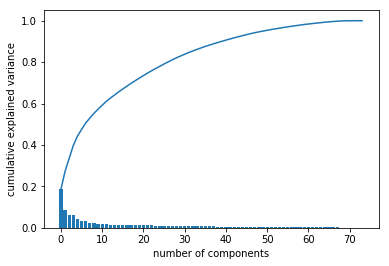

In [40]:
pca_plot(pca)

In [41]:
# Re-apply PCA to the data ing for number of components to retain.
pca_2 = PCA(n_components=40).fit(azdias_new)
#normlaiz pca
azdias_new_pca = pca_2.transform(azdias_new)


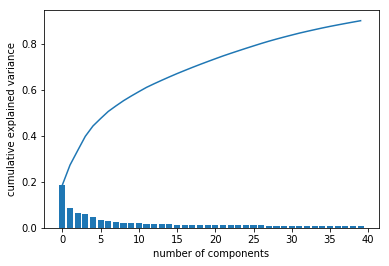

In [42]:
pca_plot(pca_2)

In [43]:
azdias_new_pca

array([[ 2.8844666 , -2.85042252,  1.01260026, ..., -0.13862029,
        -0.73186048, -0.16198827],
       [-1.13132154,  1.69524439,  0.17814104, ...,  1.03142884,
         0.05425732, -0.27390839],
       [-3.92113046,  2.54511693, -3.05565144, ..., -0.20859247,
        -0.13952584,  0.90570086],
       ..., 
       [-0.85324678, -2.41571472, -3.78624048, ..., -0.12091047,
         1.07811936,  0.82468496],
       [ 4.44833321, -4.31526165,  1.0819503 , ..., -0.4486903 ,
        -0.32365134,  0.51852348],
       [ 0.3904531 ,  1.59162213, -4.23226109, ...,  0.36711943,
        -0.73342586, -0.42045006]])

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

- The plot tells that the first 40 components have around 90% of the total variance of the data, So I have chosen 40 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [44]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
#https://datatofish.com/sort-pandas-dataframe/
def weights (com):
    df=pd.DataFrame(pca_2.components_[com])
    df.index=azdias_new.columns
    df.sort_values(by=df.columns[0], inplace=True, ascending=False)
    return df

In [45]:
pc_0=weights(0)
pc_0.columns=['PC_0']
pc_0

,PC_0
PLZ8_ANTG3,0.205847
PLZ8_ANTG4,0.200516
PLZ8_BAUMAX,0.195771
Wealth,0.193481
HH_EINKOMMEN_SCORE,0.191379
CAMEO_DEUG_2015,0.182696
ORTSGR_KLS9,0.177702
EWDICHTE,0.175703
KBA05_ANTG4,0.145745
PLZ8_ANTG2,0.138766


In [46]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc_1=weights(1)
pc_1.columns=['PC_1']
pc_1


,PC_1
ALTERSKATEGORIE_GROB,0.275741
SEMIO_ERL,0.262004
SEMIO_LUST,0.257305
FINANZ_VORSORGER,0.182456
RETOURTYP_BK_S,0.178382
W_KEIT_KIND_HH,0.144314
SEMIO_KRIT,0.117897
SEMIO_KAEM,0.106696
WOHNDAUER_2008,0.070840
FINANZ_MINIMALIST,0.062665


In [47]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc_2=weights(2)
pc_2.columns=['PC_2']
pc_2



,PC_2
LP_FAMILIE_GROB,0.331157
LP_FAMILIE_FEIN,0.326702
LP_LEBENSPHASE_GROB,0.315498
LP_LEBENSPHASE_FEIN,0.307246
ANZ_PERSONEN,0.288192
SEMIO_KAEM,0.192618
SEMIO_DOM,0.171302
ORTSGR_KLS9,0.168865
EWDICHTE,0.164303
ONLINE_AFFINITAET,0.162460


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

- from my understand in PC_0 there is a positive relationship between 'PLZ8_ANTG3' and 'PLZ8_ANTG4' and inverse relationship between them and 'MOBI_REGIO'

  in PC_1 there is a positive relationship between 'ALTERSKATEGORIE_GROB' and 'SEMIO_ERL' and 'SEMIO_LUST'
  and inverse relationship between them and 'SEMIO_PFLICHT'

  in PC_2 there is a positive relationship between 'LP_FAMILIE_GROB' and 'LP_FAMILIE_FEIN' and 'LP_LEBENSPHASE_GROB'
  and 'LP_LEBENSPHASE_FEIN'
  and inverse relationship between them and 'W_KEIT_KIND_HH'	



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [48]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.

from sklearn.cluster import KMeans

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

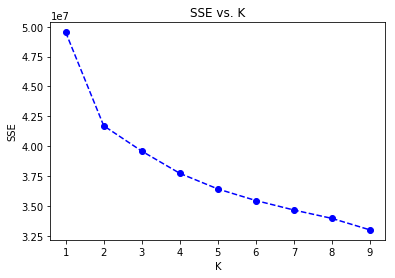

In [49]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

scores = []
centers = list(range(1,10))

for center in centers:
    scores.append(get_kmeans_score(azdias_new_pca, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');    

In [50]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

#build the model:
#intiate a model with  k cluster
kmeans = KMeans(n_clusters=5)

# Then fit the model to your data using the fit method
model = kmeans.fit(azdias_new_pca)

# Finally get the labels on the same data to show the cluster/group for each point point that belongs to
labels = model.predict(azdias_new_pca)


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

- Based on the plot the score keeps decreasing and there not many changes after 5 clusters ., so I have decided to go with 5 clusters. 


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [51]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=";")

In [52]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [114]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
c_customers = clean_data(customers)


In [116]:
#c_customers.to_csv('c_customers.csv', sep=';', index = False)

In [53]:
c_customers = pd.read_csv('c_customers.csv', delimiter=';')

In [54]:
c_customers.head()


,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,Wealth,Life_Stage_Typology
0,4.0,5.0,5.0,5.0,2.0,4.0,1,20.0,5.0,2.0,...,1.0,5.0,5.0,1.0,2.0,1.0,2.0,2.0,1.0,3.0
1,4.0,2.0,5.0,5.0,4.0,3.0,1,13.0,3.0,1.0,...,3.0,3.0,2.0,3.0,5.0,3.0,2.0,2.0,3.0,4.0
2,4.0,2.0,5.0,5.0,2.0,10.0,0,0.0,0.0,0.0,...,1.0,3.0,4.0,1.0,3.0,1.0,2.0,2.0,2.0,4.0
3,3.0,6.0,3.0,4.0,2.0,2.0,0,31.0,10.0,10.0,...,2.0,3.0,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0
4,3.0,4.0,5.0,5.0,3.0,11.0,1,17.0,5.0,2.0,...,1.0,5.0,5.0,3.0,7.0,5.0,2.0,2.0,3.0,4.0


In [55]:
c_customers["CAMEO_DEUG_2015"]= c_customers["CAMEO_DEUG_2015"].astype(float)
c_customers.describe()
c_customers.info()


,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,Wealth,Life_Stage_Typology
count,131420.000000,131420.000000,131420.000000,131420.000000,131420.000000,131420.000000,131420.000000,131420.000000,131420.000000,131420.000000,...,131420.000000,131420.000000,131420.000000,131420.000000,131420.000000,131420.000000,131420.000000,131420.000000,131420.000000,131420.000000
mean,3.601377,3.012350,4.315835,4.654824,2.924601,6.640656,0.507815,23.252184,6.931928,5.432552,...,1.560447,3.633336,3.616428,2.830810,5.125361,2.906118,2.912860,1.584203,2.598524,3.376472
std,0.555384,1.504038,0.957031,0.675851,1.137961,3.124986,0.499941,13.131277,4.265790,4.418970,...,1.189189,0.931734,1.008337,1.007679,2.154408,1.419840,1.251831,0.492861,1.410548,1.340289
min,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,2.000000,4.000000,4.000000,2.000000,4.000000,0.000000,12.000000,3.000000,1.000000,...,1.000000,3.000000,3.000000,2.000000,4.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,3.000000,5.000000,5.000000,2.000000,7.000000,1.000000,20.000000,5.000000,2.000000,...,1.000000,3.000000,4.000000,3.000000,5.000000,3.000000,3.000000,2.000000,2.000000,4.000000
75%,4.000000,4.000000,5.000000,5.000000,4.000000,10.000000,1.000000,37.000000,12.000000,10.000000,...,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000,4.000000,2.000000,4.000000,4.000000
max,4.000000,6.000000,5.000000,5.000000,5.000000,12.000000,1.000000,40.000000,12.000000,11.000000,...,5.000000,5.000000,5.000000,9.000000,9.000000,9.000000,6.000000,2.000000,5.000000,5.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131420 entries, 0 to 131419
Data columns (total 74 columns):
ALTERSKATEGORIE_GROB    131420 non-null float64
CJT_GESAMTTYP           131420 non-null float64
FINANZ_MINIMALIST       131420 non-null float64
FINANZ_VORSORGER        131420 non-null float64
FINANZ_HAUSBAUER        131420 non-null float64
GFK_URLAUBERTYP         131420 non-null float64
GREEN_AVANTGARDE        131420 non-null int64
LP_LEBENSPHASE_FEIN     131420 non-null float64
LP_LEBENSPHASE_GROB     131420 non-null float64
LP_FAMILIE_FEIN         131420 non-null float64
LP_FAMILIE_GROB         131420 non-null float64
LP_STATUS_FEIN          131420 non-null float64
LP_STATUS_GROB          131420 non-null float64
RETOURTYP_BK_S          131420 non-null float64
SEMIO_SOZ               131420 non-null float64
SEMIO_FAM               131420 non-null float64
SEMIO_REL               131420 non-null float64
SEMIO_MAT               131420 non-null float64
SEMIO_VERT              131

In [56]:
#feature transformation, PCA ,and clustering

c_customers = pd.DataFrame (transform_data.transform(c_customers),columns=c_customers.columns)
c_customers

pca_customer = pca_2.transform (c_customers)
pca_customer

customer_labels = model.predict(pca_customer)


,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,Wealth,Life_Stage_Typology
0,1.338091,0.980916,1.586767,0.960981,-1.510069,-0.981681,1.886866,0.380164,0.091819,-0.448463,...,-0.657614,1.427861,1.470464,-2.204524,-1.456114,-1.546959,-1.804579,1.886866,-1.574538,0.096222
1,1.338091,-0.971674,1.586767,0.960981,0.202750,-1.263426,1.886866,-0.179543,-0.431643,-0.702035,...,0.702933,-0.634786,-1.227613,-0.192894,-0.147717,-0.071032,-1.804579,1.886866,-0.210992,0.764337
2,1.338091,-0.971674,1.586767,0.960981,-1.510069,0.708791,-0.529979,-1.218999,-1.216837,-0.955608,...,-0.657614,-0.634786,0.571105,-2.204524,-1.019982,-1.546959,-1.804579,1.886866,-0.892765,0.764337
3,-0.167636,1.631779,-0.376248,0.040364,-1.510069,-1.545171,-0.529979,1.259704,1.400474,1.580115,...,0.022660,-0.634786,-0.328254,-0.192894,-0.147717,-1.546959,-0.359632,-0.529979,0.470780,-1.240006
4,-0.167636,0.330052,1.586767,0.960981,-0.653660,0.990537,1.886866,0.140290,0.091819,-0.448463,...,-0.657614,1.427861,1.470464,-0.192894,0.724548,1.404894,-1.804579,1.886866,-0.210992,0.764337
5,1.338091,-0.971674,1.586767,0.960981,-1.510069,0.708791,1.886866,0.380164,0.091819,-0.448463,...,-0.657614,1.427861,1.470464,-1.198709,-1.019982,-0.808996,-1.804579,1.886866,-0.892765,0.096222
6,1.338091,-0.971674,1.586767,0.960981,-1.510069,0.145301,1.886866,0.380164,0.091819,-0.448463,...,-0.657614,-0.634786,-0.328254,-0.192894,-0.583849,-0.071032,-1.804579,1.886866,-1.574538,1.432451
7,-0.167636,-0.320811,1.586767,0.040364,-1.510069,-1.826916,1.886866,1.019830,0.877012,1.072971,...,-0.657614,1.427861,1.470464,-0.192894,0.288416,0.666931,-0.359632,1.886866,-1.574538,1.432451
8,1.338091,-0.320811,1.586767,0.960981,-1.510069,-0.981681,1.886866,-0.179543,-0.431643,-0.702035,...,-0.657614,-0.634786,-0.328254,-1.198709,-0.147717,-1.546959,-1.804579,1.886866,-1.574538,0.764337
9,1.338091,0.980916,1.586767,0.040364,-1.510069,0.708791,-0.529979,0.939871,0.877012,1.072971,...,-0.657614,0.396538,1.470464,-2.204524,-1.892247,-1.546959,-0.359632,-0.529979,-0.892765,-0.571892


array([[-6.01782969,  1.49965133, -1.70025447, ...,  0.99838421,
        -0.40673561, -0.06612154],
       [-0.9278765 ,  4.82396691,  1.03541039, ..., -1.18725431,
        -0.01957627,  0.64791928],
       [-3.97376247,  1.64907162, -4.71897931, ..., -0.82654266,
        -0.84470119, -0.19756097],
       ..., 
       [-5.09315255,  1.68083005,  2.71176268, ..., -1.08427994,
         0.99274484,  0.74684272],
       [-1.40890107,  1.93452594,  3.55510567, ..., -0.37359601,
        -0.82564976, -1.31107287],
       [-5.31855572, -2.47020624, -0.74592496, ...,  0.11885453,
         0.75273952,  0.5888778 ]])

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

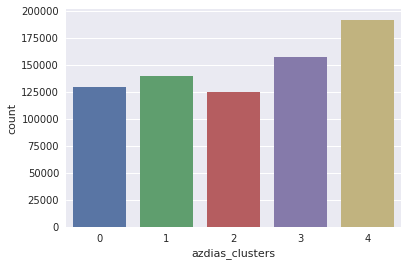

In [57]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
import seaborn as sns

customer_labels_clu=pd.DataFrame (customer_labels,columns = ['customers_clusters'])
azdias_labels_clu=pd.DataFrame (labels,columns = ['azdias_clusters'])

sns.set(style="darkgrid")
sns.countplot(x="azdias_clusters", data=azdias_labels_clu)



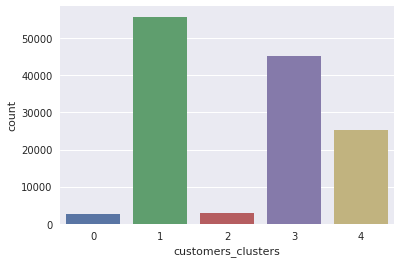

In [58]:

sns.countplot(x="customers_clusters", data=customer_labels_clu)


In [61]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

over = transform_data.inverse_transform(pca_2.inverse_transform(pca_customer[np.where(customer_labels==1)])).round()
df_over = pd.DataFrame(data = over, columns = c_customers.columns)
df_over.head(10)

,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,Wealth,Life_Stage_Typology
0,3.0,3.0,5.0,4.0,2.0,1.0,1.0,32.0,9.0,7.0,...,1.0,5.0,5.0,3.0,6.0,4.0,4.0,2.0,1.0,5.0
1,4.0,4.0,5.0,4.0,2.0,10.0,-0.0,29.0,9.0,7.0,...,1.0,4.0,5.0,1.0,1.0,1.0,4.0,1.0,2.0,2.0
2,3.0,3.0,5.0,5.0,2.0,5.0,1.0,42.0,12.0,11.0,...,1.0,5.0,6.0,2.0,6.0,1.0,3.0,2.0,1.0,5.0
3,3.0,2.0,5.0,5.0,2.0,10.0,1.0,39.0,12.0,10.0,...,0.0,3.0,4.0,3.0,5.0,3.0,3.0,2.0,1.0,5.0
4,3.0,5.0,4.0,4.0,2.0,8.0,1.0,40.0,12.0,11.0,...,2.0,6.0,5.0,1.0,5.0,0.0,4.0,2.0,1.0,4.0
5,4.0,2.0,4.0,5.0,3.0,10.0,0.0,41.0,12.0,11.0,...,1.0,3.0,3.0,2.0,5.0,3.0,3.0,1.0,3.0,3.0
6,3.0,3.0,4.0,4.0,2.0,9.0,1.0,31.0,9.0,8.0,...,1.0,3.0,4.0,1.0,2.0,1.0,5.0,2.0,2.0,2.0
7,4.0,2.0,5.0,5.0,3.0,10.0,-0.0,38.0,11.0,9.0,...,1.0,5.0,5.0,1.0,1.0,1.0,2.0,1.0,2.0,5.0
8,3.0,3.0,4.0,3.0,2.0,11.0,1.0,39.0,12.0,11.0,...,2.0,4.0,3.0,3.0,7.0,4.0,4.0,2.0,3.0,4.0
9,3.0,2.0,4.0,3.0,2.0,5.0,1.0,36.0,11.0,10.0,...,1.0,4.0,5.0,2.0,2.0,2.0,4.0,2.0,2.0,4.0


In [63]:
df_over.ALTERSKATEGORIE_GROB.value_counts()

4.0    29377
3.0    24690
2.0     1674
5.0        3
1.0        1
Name: ALTERSKATEGORIE_GROB, dtype: int64

In [62]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

under = transform_data.inverse_transform(pca_2.inverse_transform(pca_customer[np.where(customer_labels==0)])).round()
df_under = pd.DataFrame(data = under, columns = c_customers.columns)
df_under.head(10)

,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,Wealth,Life_Stage_Typology
0,2.0,4.0,4.0,2.0,2.0,10.0,1.0,10.0,3.0,1.0,...,2.0,6.0,5.0,2.0,4.0,3.0,6.0,2.0,1.0,5.0
1,3.0,6.0,3.0,3.0,2.0,1.0,1.0,18.0,6.0,6.0,...,2.0,5.0,4.0,4.0,7.0,3.0,4.0,2.0,2.0,4.0
2,2.0,4.0,3.0,4.0,2.0,7.0,-0.0,6.0,2.0,0.0,...,1.0,4.0,4.0,2.0,6.0,2.0,5.0,1.0,4.0,1.0
3,3.0,4.0,3.0,4.0,3.0,11.0,1.0,32.0,10.0,9.0,...,2.0,3.0,3.0,3.0,6.0,4.0,4.0,2.0,3.0,5.0
4,3.0,2.0,3.0,2.0,3.0,5.0,0.0,11.0,3.0,3.0,...,1.0,5.0,6.0,2.0,2.0,0.0,5.0,1.0,1.0,2.0
5,2.0,4.0,3.0,3.0,3.0,3.0,1.0,12.0,3.0,3.0,...,2.0,5.0,4.0,2.0,5.0,2.0,5.0,2.0,1.0,4.0
6,2.0,4.0,4.0,5.0,2.0,1.0,-0.0,12.0,3.0,1.0,...,1.0,2.0,3.0,4.0,3.0,2.0,4.0,1.0,4.0,3.0
7,4.0,5.0,3.0,5.0,5.0,8.0,0.0,7.0,2.0,1.0,...,1.0,3.0,3.0,2.0,2.0,3.0,3.0,1.0,4.0,1.0
8,2.0,6.0,4.0,5.0,2.0,1.0,-0.0,17.0,5.0,3.0,...,1.0,3.0,3.0,4.0,8.0,4.0,4.0,1.0,4.0,3.0
9,3.0,4.0,2.0,2.0,2.0,3.0,-0.0,20.0,6.0,7.0,...,1.0,4.0,4.0,4.0,8.0,4.0,6.0,1.0,1.0,2.0


In [64]:
df_under.ALTERSKATEGORIE_GROB.value_counts()

3.0    1300
2.0    1168
4.0      97
1.0       4
Name: ALTERSKATEGORIE_GROB, dtype: int64

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

- based on the bar chart there is some difference between clusters in customer data and general population data as shown in the clusters 0 and 2 have not a lot of data compared to the same clusters in general population, and maybe the columns that we have removed and the rows have some effect on that.

- To get the overrepresented and underrepresented of the customers data, I have decided to compare based on the first column which is 'ALTERSKATEGORIE_GROB', so as you can see on the overrepresented which is cluster 1 and it has the most people from 46 to 60 then greater than 60 years old so they are old people.
  in the underrepresented which is cluster 0 and it has the most people from 30 to 45 then 46 to 60 years old so they are   younger.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.